In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from google.colab import drive 
import seaborn as sns
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]


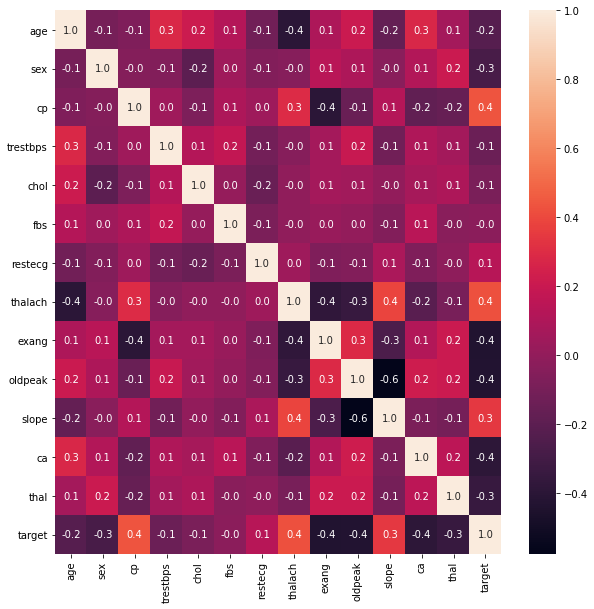

exang      -0.436757
oldpeak    -0.430696
ca         -0.391724
thal       -0.344029
sex        -0.280937
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
slope       0.345877
thalach     0.421741
cp          0.433798
target      1.000000
Name: target, dtype: float64

In [52]:
# read the data
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/heart.csv')
print(df.head())    
df.describe()
df.describe()  
df.shape 
df.isnull().values.any()   
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt='.1f')
plt.show()

   
corr_target=df[df.columns[1:]].corr()['target'][:].sort_values(kind="quicksort")#except age
display(corr_target)


In [53]:
drop_list=[]
for i in range(len(corr_target.values)):
  if(corr_target.values[i]>-0.2 and corr_target.values[i]<0.2):
    drop_list.append(corr_target.index[i])
df=df.drop(drop_list, axis = 1)
df.head() 

,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,150,0,2.3,0,0,1,1
1,37,1,2,187,0,3.5,0,0,2,1
2,41,0,1,172,0,1.4,2,0,2,1
3,56,1,1,178,0,0.8,2,0,2,1
4,57,0,0,163,1,0.6,2,0,2,1


In [54]:
def calcNewNormalDist(priorMean,priorSD,observedArray,updateSD,rowCount):
  observedMean=np.average(observedArray)
  if updateSD:
    observedSD=np.std(observedArray)
  else:
    observedSD=priorSD
    posteriorSD=priorSD
  n=len(observedArray)
  #posteriorMean=(observedSD**2*priorMean+n*priorSD**2*observedMean)/(n*priorSD**2+observedSD**2)
  #posteriorMean=(observedSD**2*priorMean*rowCount+n*priorSD**2*observedMean)/(n*priorSD**2+observedSD**2+rowCount-1)
  posteriorMean=(priorMean*rowCount+n*observedMean)/(n+rowCount)
  if updateSD:
    posteriorSD=(observedSD**2*priorSD**2)/(n*priorSD**2+observedSD**2)
  #print (f'{posteriorMean},{posteriorSD}')
  return [posteriorMean,posteriorSD]

Prior:
{'age': array([54.36633663,  9.06710164]), 'sex': array([0.68316832, 0.46524119]), 'cp': array([0.9669967 , 1.03034803]), 'thalach': array([149.64686469,  22.86733258]), 'exang': array([0.32673267, 0.46901859]), 'oldpeak': array([1.03960396, 1.15915747]), 'slope': array([1.39933993, 0.61520843]), 'ca': array([0.72937294, 1.0209175 ]), 'thal': array([2.31353135, 0.61126531])}


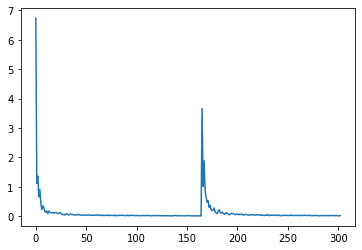

Posterior:
0 - {'age': [56.60144927536233, 9.067101638577872], 'sex': [0.8260869565217391, 0.46524119304834577], 'cp': [0.4782608695652174, 1.0303480250839463], 'thalach': [139.1014492753623, 22.86733258188924], 'exang': [0.5507246376811594, 0.46901858543869346], 'oldpeak': [1.585507246376812, 1.1591574732421364], 'slope': [1.166666666666667, 0.6152084301256651], 'ca': [1.1666666666666667, 1.0209175011165652], 'thal': [2.5434782608695654, 0.6112653149988239]}
1 - {'age': [52.49696969696972, 9.067101638577872], 'sex': [0.5636363636363633, 0.46524119304834577], 'cp': [1.375757575757576, 1.0303480250839463], 'thalach': [158.46666666666667, 22.86733258188924], 'exang': [0.1393939393939394, 0.46901858543869346], 'oldpeak': [0.583030303030303, 1.1591574732421364], 'slope': [1.593939393939394, 0.6152084301256651], 'ca': [0.3636363636363637, 1.0209175011165652], 'thal': [2.121212121212122, 0.6112653149988239]}


In [55]:
# the probability distribution: theta(x|s,a) = theta[s][a][x]
#theta = np.ones([11, 11, 11]) / 11.0

theta=[0]*2
theta[0]={}
theta[1]={}


for feature in df.columns:
  if feature!='target':
    for t in range(2):
      theta[t][feature]=np.ones(2)
      theta[t][feature][0]=np.average(df[feature].values)
      theta[t][feature][1]=np.std(df[feature].values)

print('Prior:')
print(str(theta[0]))


D_KL = []

tempData=[0]*2
tempData[0]={}
tempData[1]={}


rowCount=[0]*2
# for each line in the data
for irow in df.iterrows():
  row = irow[1]
  D_KL_t = 0.0
  for feature in row.keys():
    if feature!='target':
      relevantTheta=theta[int(row['target'])]
      relevantTempData=tempData[int(row['target'])]
      if feature not in relevantTempData:
        relevantTempData[feature]=[]

      pOfXBefore=scipy.stats.norm(relevantTheta[feature][0],relevantTheta[feature][1]).pdf(row[feature])

      relevantTempData[feature].append(row[feature])
      if len(relevantTempData[feature])==1:
        relevantTheta[feature]=calcNewNormalDist(relevantTheta[feature][0],relevantTheta[feature][1],relevantTempData[feature],False,rowCount[int(row['target'])])
        relevantTempData[feature]=[]
      
      pOfXAfter=scipy.stats.norm(relevantTheta[feature][0],relevantTheta[feature][1]).pdf(row[feature])
      if pOfXBefore > 0.0 and pOfXAfter > 0.0:
          D_KL_t += pOfXAfter * np.log2(pOfXAfter / pOfXBefore)
  D_KL.append(D_KL_t)
  rowCount[int(row['target'])]+=1

plt.plot(D_KL)
plt.show()

print('Posterior:') 
print('0 - '+str(theta[0]))
print('1 - '+str(theta[1]))